In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import rpy2.robjects as robjects

In [ ]:
!pip install -Iv rpy2==3.4.2

### Problem 1

Reproduce a figure from ESL Chapter 5: Figure 5.6 using smoothing splines to fit bone density data in adolescents.

In [28]:
bone_density = pd.read_csv("bone-data.txt", delimiter='\t')
bone_density.head()

,idnum,age,gender,spnbmd
0,1,11.70,male,0.018081
1,1,12.70,male,0.060109
2,1,13.75,male,0.005858
3,2,13.25,male,0.010264
4,2,14.30,male,0.210526


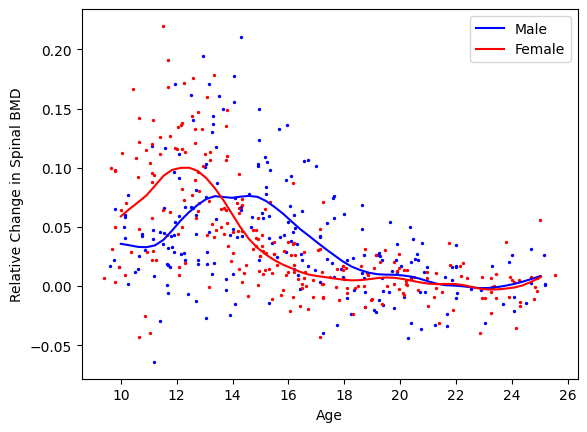

In [45]:
male = bone_density[bone_density["gender"]=="male"]
female = bone_density[bone_density["gender"]=="female"]

## Out-of-the-box smoothing splines are not implemented for python. I used the following resources to access the R function
## https://stackoverflow.com/questions/29312005/is-there-a-python-equivalent-to-the-smooth-spline-function-in-r
## https://stackoverflow.com/questions/58239011/how-to-use-the-lambda-argument-of-smooth-spline-in-rpy-without-python-interprati

male_x = robjects.FloatVector(male["age"])
male_y = robjects.FloatVector(male["spnbmd"])
male_smooth_spline = robjects.r['smooth.spline']
kwargs = {"x": male_x, "y": male_y, "lambda":  0.00022}
male_spline = r_smooth_spline(**kwargs)

female_x = robjects.FloatVector(female["age"])
female_y = robjects.FloatVector(female["spnbmd"])
female_smooth_spline = robjects.r['smooth.spline']
kwargs = {"x": female_x, "y": female_y, "lambda":  0.00022}
female_spline = r_smooth_spline(**kwargs)

x_smooth = np.linspace(10, 25)

male_ySpline=np.array(robjects.r['predict'](male_spline,robjects.FloatVector(x_smooth)).rx2('y'))
female_ySpline=np.array(robjects.r['predict'](female_spline,robjects.FloatVector(x_smooth)).rx2('y'))
plt.plot(x_smooth,male_ySpline, c='b', label="Male")
plt.plot(x_smooth,female_ySpline, c='r', label="Female")

plt.scatter(male["age"], male["spnbmd"], c='b', s=2)
plt.scatter(female["age"], female["spnbmd"], c='r', s=2)
plt.legend(loc="best")
plt.xlabel("Age")
plt.ylabel("Relative Change in Spinal BMD")
plt.show()

### Problem 2

Using the South Africa coronary heart disease data; construct b-spline, natural spline, and truncated polynomial spline bases (all with 6 knots). Fit a logistic regression using each of these bases. Compute the predicted value and the predicted variance for the linear predictor (i.e. on the log-odds scale), without using the built-in prediction methods. Plot the predictions ± 1 SE for each of the three bases.

In [2]:
heart_disease = pd.read_csv("SAheart-data.txt", delimiter=',', index_col="row.names")
heart_disease.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


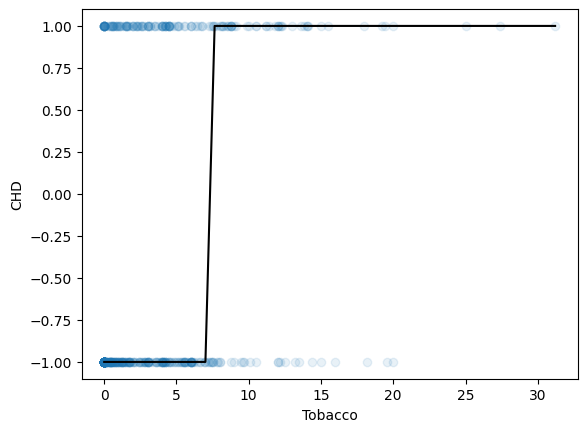

In [11]:
## using B-splines to transform features: https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html#sphx-glr-auto-examples-linear-model-plot-polynomial-interpolation-py

tobacco = heart_disease["tobacco"].to_numpy()
tobacco = tobacco[:,np.newaxis]
chd = heart_disease["chd"].to_numpy(dtype=float)
chd[chd==0] = -1

xrange = np.linspace(np.min(tobacco), np.max(tobacco))

model = make_pipeline(SplineTransformer(n_knots=5, degree=3, knots="quantile"), LogisticRegression(penalty="none")) # switch off automatic regularization on Logistic Regression
model.fit(tobacco, chd)
y_pred = model.predict_proba(xrange[:,np.newaxis])
plt.plot(xrange, model.predict(xrange[:,np.newaxis]), c='k')

plt.scatter(tobacco, chd, alpha=0.1)
plt.xlabel("Tobacco")
plt.ylabel("CHD")
plt.show()

Computing predicted values and variance:

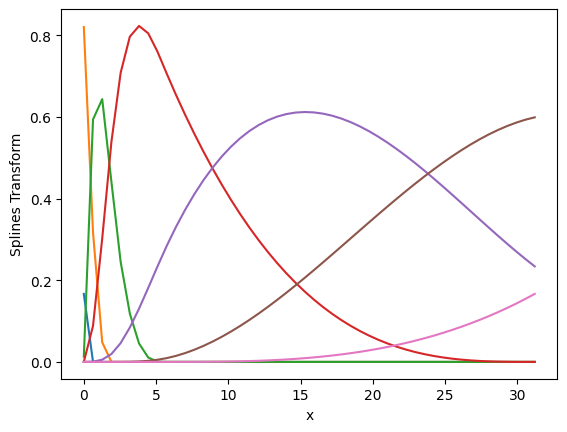

In [12]:
log_reg = model.named_steps['logisticregression']
splines = model.named_steps["splinetransformer"]
spline_transform = splines.transform(xrange[:,np.newaxis])

## we can plot the splines
plt.plot(xrange, spline_transform)
plt.xlabel("x")
plt.ylabel("Splines Transform")
plt.show()

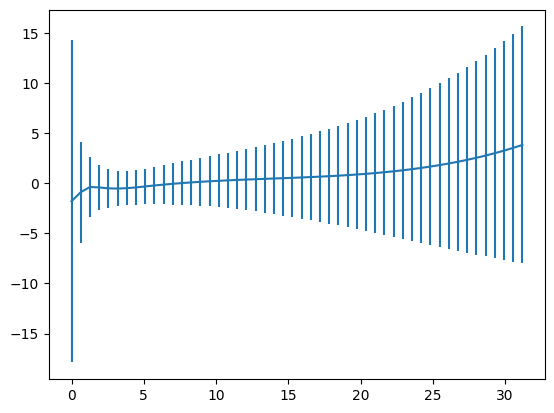

In [13]:
## calculating the variance on the bias + spline coefficients

H = spline_transform
W = np.diag(y_pred[:,0] * y_pred[:,1])
cov = np.linalg.inv(H.T @ W @ H)
variance = np.diag(cov)
std = np.sqrt(variance)

plt.errorbar(xrange, spline_transform @ log_reg.coef_[0]+log_reg.intercept_[0], yerr=H@std)
plt.show()

The variances on the coefficients are huge? Without errorbars, the logodds are:

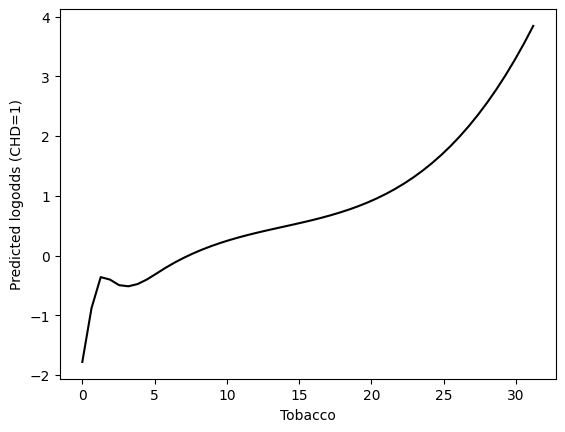

In [14]:
plt.plot(xrange, np.matmul(spline_transform, log_reg.coef_[0])+log_reg.intercept_[0], c='k')
plt.xlabel("Tobacco")
plt.ylabel("Predicted logodds (CHD=1)")
plt.show()

Sorry, I ran out of time for the rest of the homework again. 

### Problem 4

Write a function, starting from the truncated polynomial basis function presented in the notes (or write your own), that adds a natural spline constraint by using the constraint equations described [here](https://stats.stackexchange.com/questions/172217/why-are-the-basis-functions-for-natural-cubic-splines-expressed-as-they-are-es). In addition to the `x`, `df` arguments your function should take a `natural` argument that is true or false to decide whether to impose the constraint. Plot an example of regular and natural bases side-by-side.

### Problem 5

1. Write a function to simulate data drawn from a smooth two-dimensional surface on the unit square with Gaussian noise. You could use (for example) a reasonably high-order bivariate polynomial, or a kernel function/mixture model (i.e. $f(x,y)=\sum_j w_j \exp(((x−x_j)^2+(y−y_j)^2)/s^2_j))$, or using a 2D spline.

2. Use `mgcv::gam()` to fit two-dimensional splines to your simulated data, using `z ~ te(gp, x, y)`. Over an ensemble of 250 simulations, compute the average computation time, bias, variance, and mean-squared error of your predictions for (i) `method = "GCV.Cp"` (generalized cross-validation) and (ii) `method = "REML"` (restricted maximum likelihood).